In [ ]:
#!pip install pytorch-metric-learning
#!pip install faiss-cpu

In [ ]:
#!/bin/bash
#!curl -L -o ./avengers-faces-dataset.zip https://www.kaggle.com/api/v1/datasets/download/yasserh/avengers-faces-dataset

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 89.5M  100 89.5M    0     0  3778k      0  0:00:24  0:00:24 --:--:-- 3946k


In [ ]:
#!unzip ./avengers-faces-dataset.zip

In [ ]:
#!curl -L -o ./face-recognition-dataset.zip https://www.kaggle.com/api/v1/datasets/download/vasukipatel/face-recognition-dataset

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100  725M  100  725M    0     0  3825k      0  0:03:14  0:03:14 --:--:-- 4049k2:00 3955k0:03:18  0:02:04  0:01:14 3731k


In [ ]:
#!unzip ./face-recognition-dataset.zip

In [1]:
from tqdm import tqdm
import torch
from torchvision import models
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from pytorch_metric_learning.utils.inference import InferenceModel, MatchFinder, CosineSimilarity
import torch.optim as optim
from pytorch_metric_learning import losses
import pandas as pd

In [2]:
from torch.utils.data import Dataset
from PIL import Image
import os
import torch
import pandas as pd

class CustomImageDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):
        self.img_labels = annotations_file
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform
        self.label_map = self._create_label_map()

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        image = Image.open(img_path).convert("RGB")
        label_str = self.img_labels.iloc[idx, 1]
        # label = torch.tensor(self.label_map[label_str])
        label = self.label_map[label_str]


        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

    def _create_label_map(self):
        unique_labels = self.img_labels.iloc[:, 1].unique()
        return {label: i for i, label in enumerate(unique_labels)}

    def get_label_map(self):
        return self.label_map

In [3]:
N_CLASSES = 31

In [4]:
#loss_func = losses.TripletMarginLoss()

from pytorch_metric_learning.losses import ArcFaceLoss
#loss_func = ArcFaceLoss(num_classes=N_CLASSES, embedding_size=128)
#loss_func = ArcFaceLoss(num_classes=N_CLASSES, embedding_size=2048) # resnet50
loss_func = ArcFaceLoss(num_classes=N_CLASSES, embedding_size=128) # resnet18


In [5]:
# MARVEL Dataset

# data_dir = './images/train' # marvel 

# transform = models.ResNet50_Weights.IMAGENET1K_V1.transforms()
# image_dataset = datasets.ImageFolder(data_dir, transform=transform)
# dataloader = DataLoader(image_dataset, batch_size=16, shuffle=True)

In [6]:
labels_df = pd.read_csv('./lbl_face.csv')
data_dir = './Faces/Faces'
#transform = models.ResNet50_Weights.IMAGENET1K_V1.transforms()
transform = models.ResNet18_Weights.IMAGENET1K_V1.transforms()

image_dataset = CustomImageDataset(annotations_file=labels_df, img_dir=data_dir, transform=transform)

# Save the label mapping
label_map = image_dataset.get_label_map()
import json
with open('label_map.json', 'w') as f:
    json.dump(label_map, f)

dataloader = DataLoader(image_dataset, batch_size=32, shuffle=True)

In [7]:
#model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)
model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)

In [8]:
#model = torch.nn.Sequential(*(list(model.children())[:-1]))
#model.add_module("flatten", torch.nn.Flatten())

model = torch.nn.Sequential(
    *(list(model.children())[:-1]),
    torch.nn.Flatten(),
   # torch.nn.Linear(2048, 128),  # learnable embedding layer
    torch.nn.Linear(512, 128),  # learnable embedding layer
    torch.nn.BatchNorm1d(128),   # often improves metric learning
)

In [9]:
model

Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Con

In [10]:
device = torch.device('cuda')
model = model.to(device)

In [11]:
optimizer = optim.SGD(model.parameters(), lr=0.0001)

In [12]:
model.train()
for epoch in range(50):
	for i, (data, labels) in tqdm(enumerate(dataloader)):
		data, labels = data.to(device), labels.to(device)
		optimizer.zero_grad()
		embeddings = model(data)
		loss = loss_func(embeddings, labels)
		loss.backward()
		optimizer.step()
	print(f'Epoch {epoch+1}, Loss: {loss.item()}')
    

81it [00:05, 15.75it/s]


Epoch 1, Loss: 45.049896240234375


81it [00:04, 17.08it/s]


Epoch 2, Loss: 43.50351333618164


81it [00:04, 17.22it/s]


Epoch 3, Loss: 41.06928253173828


81it [00:04, 16.91it/s]


Epoch 4, Loss: 41.05463409423828


81it [00:04, 16.87it/s]


Epoch 5, Loss: 34.166744232177734


81it [00:04, 16.92it/s]


Epoch 6, Loss: 36.917022705078125


81it [00:04, 17.13it/s]


Epoch 7, Loss: 24.547460556030273


81it [00:04, 17.26it/s]


Epoch 8, Loss: 42.76325225830078


81it [00:04, 17.30it/s]


Epoch 9, Loss: 38.08896255493164


81it [00:04, 17.22it/s]


Epoch 10, Loss: 27.133464813232422


81it [00:04, 17.04it/s]


Epoch 11, Loss: 28.94716453552246


81it [00:04, 16.97it/s]


Epoch 12, Loss: 27.816349029541016


81it [00:04, 17.17it/s]


Epoch 13, Loss: 25.120529174804688


81it [00:04, 17.13it/s]


Epoch 14, Loss: 34.303733825683594


81it [00:04, 17.09it/s]


Epoch 15, Loss: 21.432266235351562


81it [00:04, 17.19it/s]


Epoch 16, Loss: 28.09494972229004


81it [00:04, 17.15it/s]


Epoch 17, Loss: 23.205989837646484


81it [00:04, 16.65it/s]


Epoch 18, Loss: 29.001800537109375


81it [00:04, 16.75it/s]


Epoch 19, Loss: 23.2567138671875


81it [00:04, 16.90it/s]


Epoch 20, Loss: 26.038421630859375


81it [00:04, 17.04it/s]


Epoch 21, Loss: 46.448970794677734


81it [00:04, 17.04it/s]


Epoch 22, Loss: 21.94065284729004


81it [00:04, 17.31it/s]


Epoch 23, Loss: 28.686241149902344


81it [00:04, 16.90it/s]


Epoch 24, Loss: 28.59081268310547


81it [00:04, 16.90it/s]


Epoch 25, Loss: 35.56199264526367


81it [00:04, 16.93it/s]


Epoch 26, Loss: 24.043954849243164


81it [00:04, 17.08it/s]


Epoch 27, Loss: 21.795095443725586


81it [00:04, 16.93it/s]


Epoch 28, Loss: 16.560169219970703


81it [00:04, 16.92it/s]


Epoch 29, Loss: 24.024227142333984


81it [00:04, 17.37it/s]


Epoch 30, Loss: 24.296926498413086


81it [00:04, 17.09it/s]


Epoch 31, Loss: 17.202926635742188


81it [00:04, 17.22it/s]


Epoch 32, Loss: 23.842376708984375


81it [00:04, 17.25it/s]


Epoch 33, Loss: 15.363837242126465


81it [00:04, 17.21it/s]


Epoch 34, Loss: 19.2163143157959


81it [00:04, 17.18it/s]


Epoch 35, Loss: 29.885421752929688


81it [00:04, 17.29it/s]


Epoch 36, Loss: 26.40271759033203


81it [00:04, 17.27it/s]


Epoch 37, Loss: 30.482345581054688


81it [00:04, 17.09it/s]


Epoch 38, Loss: 18.240154266357422


81it [00:04, 17.42it/s]


Epoch 39, Loss: 22.381145477294922


81it [00:04, 17.40it/s]


Epoch 40, Loss: 24.082340240478516


81it [00:04, 17.36it/s]


Epoch 41, Loss: 27.825897216796875


81it [00:04, 17.33it/s]


Epoch 42, Loss: 18.649372100830078


81it [00:04, 17.12it/s]


Epoch 43, Loss: 21.929828643798828


81it [00:04, 17.26it/s]


Epoch 44, Loss: 14.943416595458984


81it [00:04, 17.15it/s]


Epoch 45, Loss: 20.549270629882812


81it [00:04, 17.21it/s]


Epoch 46, Loss: 17.89996337890625


81it [00:04, 17.27it/s]


Epoch 47, Loss: 28.18359375


81it [00:04, 17.27it/s]


Epoch 48, Loss: 37.15584945678711


81it [00:04, 17.08it/s]


Epoch 49, Loss: 34.61091613769531


81it [00:04, 17.11it/s]

Epoch 50, Loss: 30.684284210205078


In [ ]:
torch.save(model.state_dict(), 'face_recognition_model_weights_resnet18_epoch50_fc.pth')

In [14]:
model.load_state_dict(torch.load('face_recognition_model_weights_resnet18_epoch50_fc.pth'))

<All keys matched successfully>

In [15]:
model.eval()
InferenceModel(model,
                embedder=None,
                match_finder=MatchFinder(distance=CosineSimilarity(), threshold=0.9),
                normalize_embeddings=True,
                knn_func=None,
                data_device=None,
                dtype=None)

In [16]:
# initialize with a model
im = InferenceModel(model)

# pass in a dataset to serve as the search space for k-nn
im.train_knn(image_dataset)

/home/sciro/anaconda3/envs/superhome/lib/python3.8/site-packages/faiss/contrib/torch_utils.py:51: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  x.storage().data_ptr() + x.storage_offset() * 4)


In [15]:
len(image_dataset)

2562

In [31]:
def inverse_transform(img_tensor):
    # Inverse normalization for ImageNet
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
    img = img_tensor.clone().cpu()
    img = img * std + mean
    img = img.clamp(0, 1)
    return img

In [17]:
QUERY_INDEX = 0

# Inference for Original Query

In [ ]:
# Load the query image

query = image_dataset[QUERY_INDEX][0]
query = query.unsqueeze(0)

# get the 10 nearest neighbors of a query
distances, indices = im.get_nearest_neighbors(query, k=30)

In [ ]:
# determine if inputs are close to each other
#is_match = im.is_match(x, y)

# determine "is_match" pairwise for all elements in a batch
#match_matrix = im.get_matches(x)

# save and load the knn function (which is a faiss index by default)
#im.save_knn_func("filename.index")
#im.load_knn_func("filename.index")

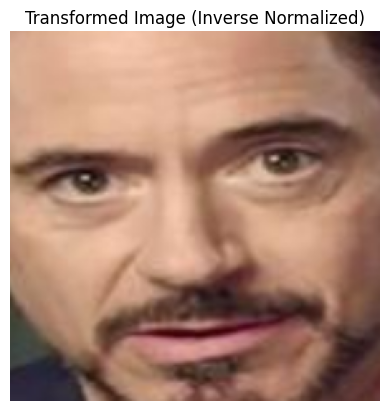

In [32]:
import matplotlib.pyplot as plt

img_tensor = image_dataset[QUERY_INDEX][0]
img = inverse_transform(img_tensor).permute(1, 2, 0).numpy()

plt.imshow(img)
plt.title("Transformed Image (Inverse Normalized)")
plt.axis('off')
plt.show()

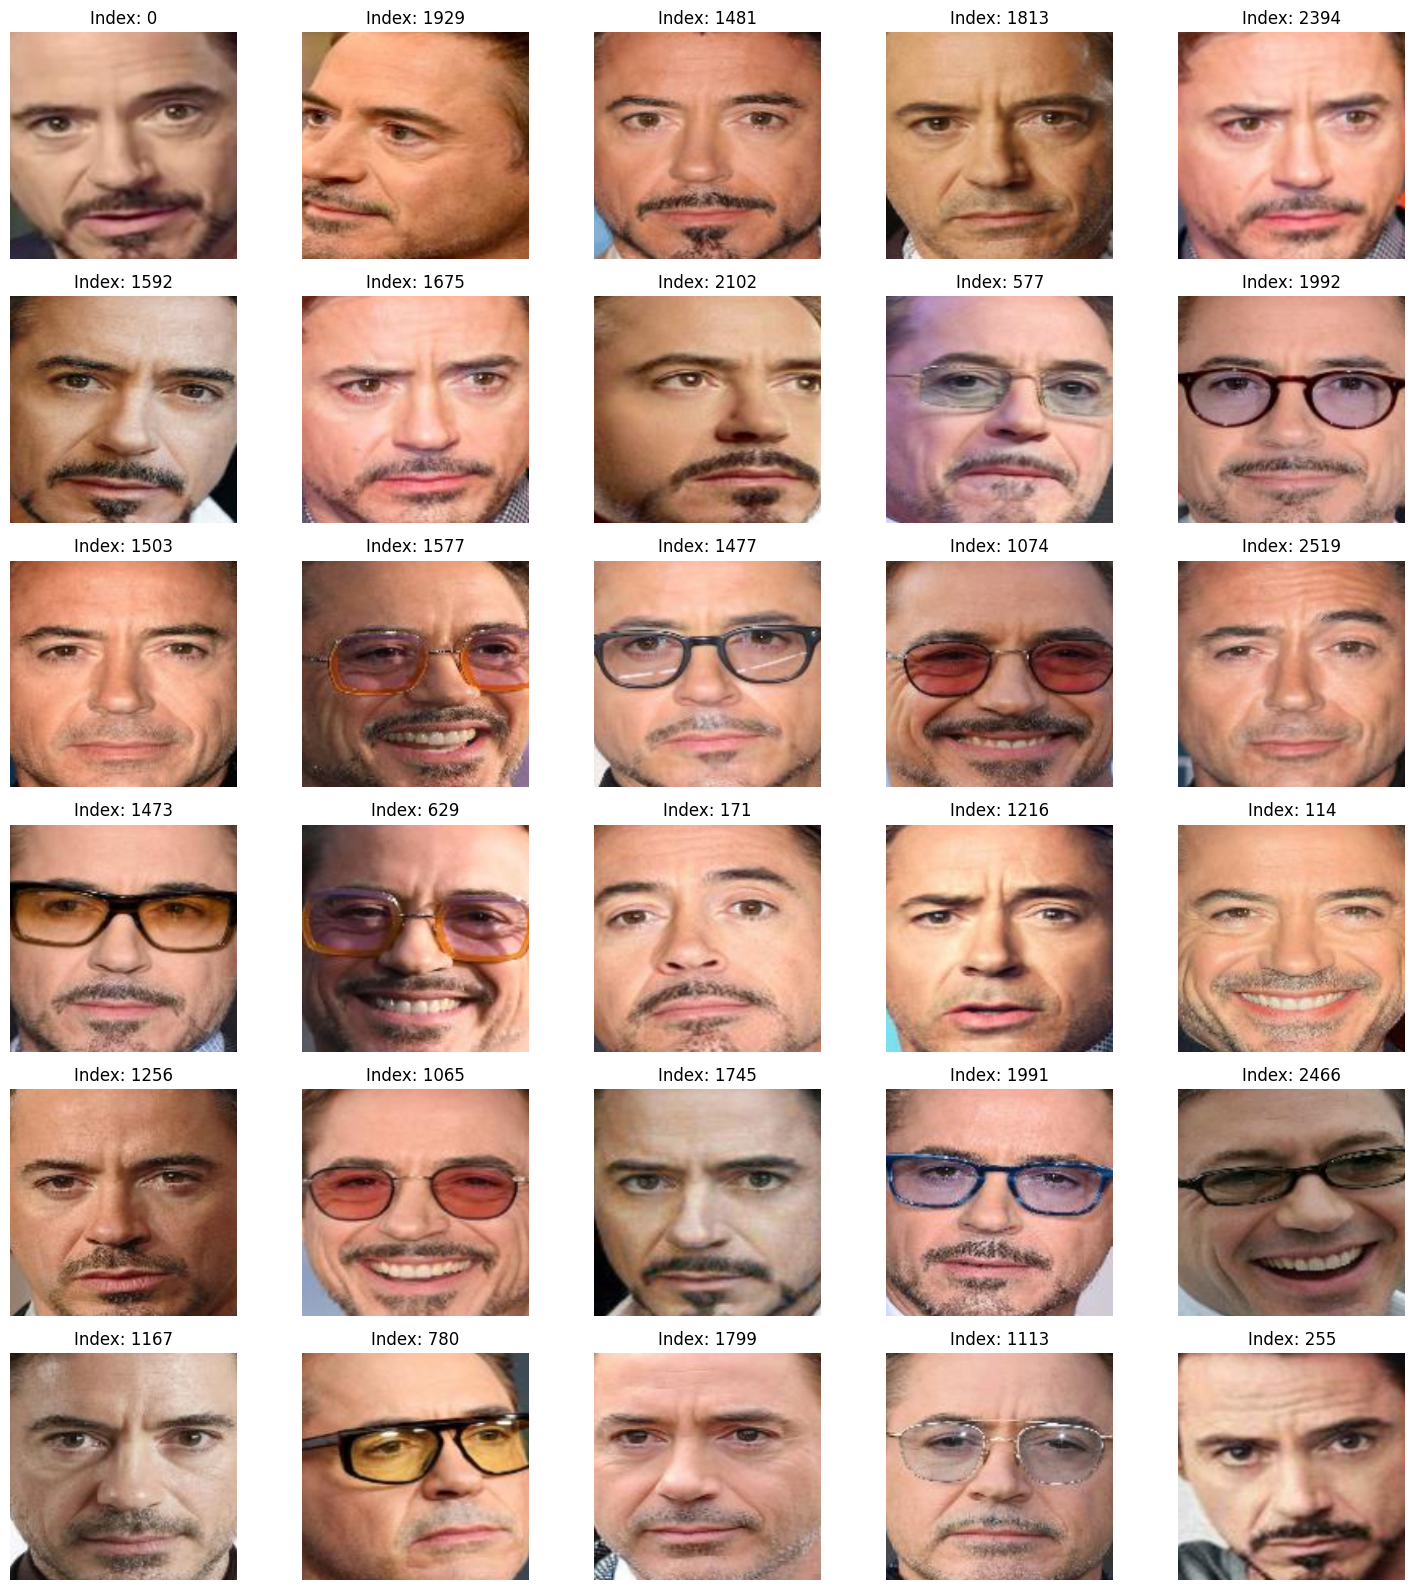

In [33]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(6, 5, figsize=(15, 16))
axes = axes.flatten()

for idx, ax in zip(indices[0].tolist(), axes):
    img_tensor = image_dataset[idx][0]
    img = inverse_transform(img_tensor).permute(1, 2, 0).numpy()
    ax.imshow(img)
    ax.axis('off')
    ax.set_title(f'Index: {idx}')

plt.tight_layout()
plt.show()

In [23]:
distances

tensor([[1.1884e-11, 1.1001e+00, 1.1164e+00, 1.1246e+00, 1.1412e+00, 1.1415e+00,
         1.1455e+00, 1.1461e+00, 1.1521e+00, 1.1630e+00, 1.1684e+00, 1.1769e+00,
         1.1919e+00, 1.2055e+00, 1.2138e+00, 1.2229e+00, 1.2237e+00, 1.2303e+00,
         1.2360e+00, 1.2444e+00, 1.2481e+00, 1.2483e+00, 1.2600e+00, 1.2736e+00,
         1.2742e+00, 1.2821e+00, 1.2869e+00, 1.2908e+00, 1.2960e+00, 1.2982e+00]],
       device='cuda:0')

# Inference for Adversarial Query ( Carlini L2 )

In [44]:
#  Load adverasarial image and get nearest neighbors

import numpy as np
import torch

# Load the adversarial image from .npy file
adv_img_np = np.load('./Faces/FacesAdv_Carlini/adv_np/00000.npy') # Carlini L2 
#adv_img_np = np.load('./Faces/FacesAdv_PGD/adv_np/00000.npy') # PGD

# Convert to torch tensor and add batch dimension if needed
adv_img_tensor = torch.tensor(adv_img_np, dtype=torch.float32)
if adv_img_tensor.ndim == 3:
    adv_img_tensor = adv_img_tensor.unsqueeze(0)

# Move to the correct device
adv_img_tensor = adv_img_tensor.to(device)

# Get the 30 nearest neighbors using the adversarial image as query
distances, indices = im.get_nearest_neighbors(adv_img_tensor, k=30)

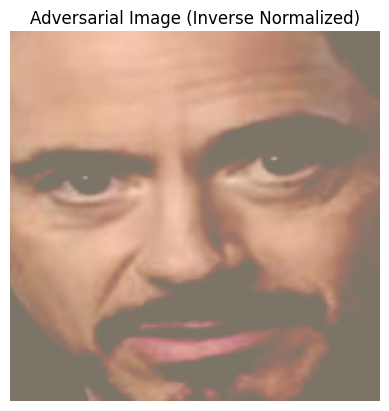

In [45]:
import matplotlib.pyplot as plt

# Remove batch dimension if present
adv_img = adv_img_tensor.squeeze().detach().cpu()
# Inverse normalize
adv_img_vis = inverse_transform(adv_img).permute(1, 2, 0).numpy()

plt.imshow(adv_img_vis)
plt.title("Adversarial Image (Inverse Normalized)")
plt.axis('off')
plt.show()

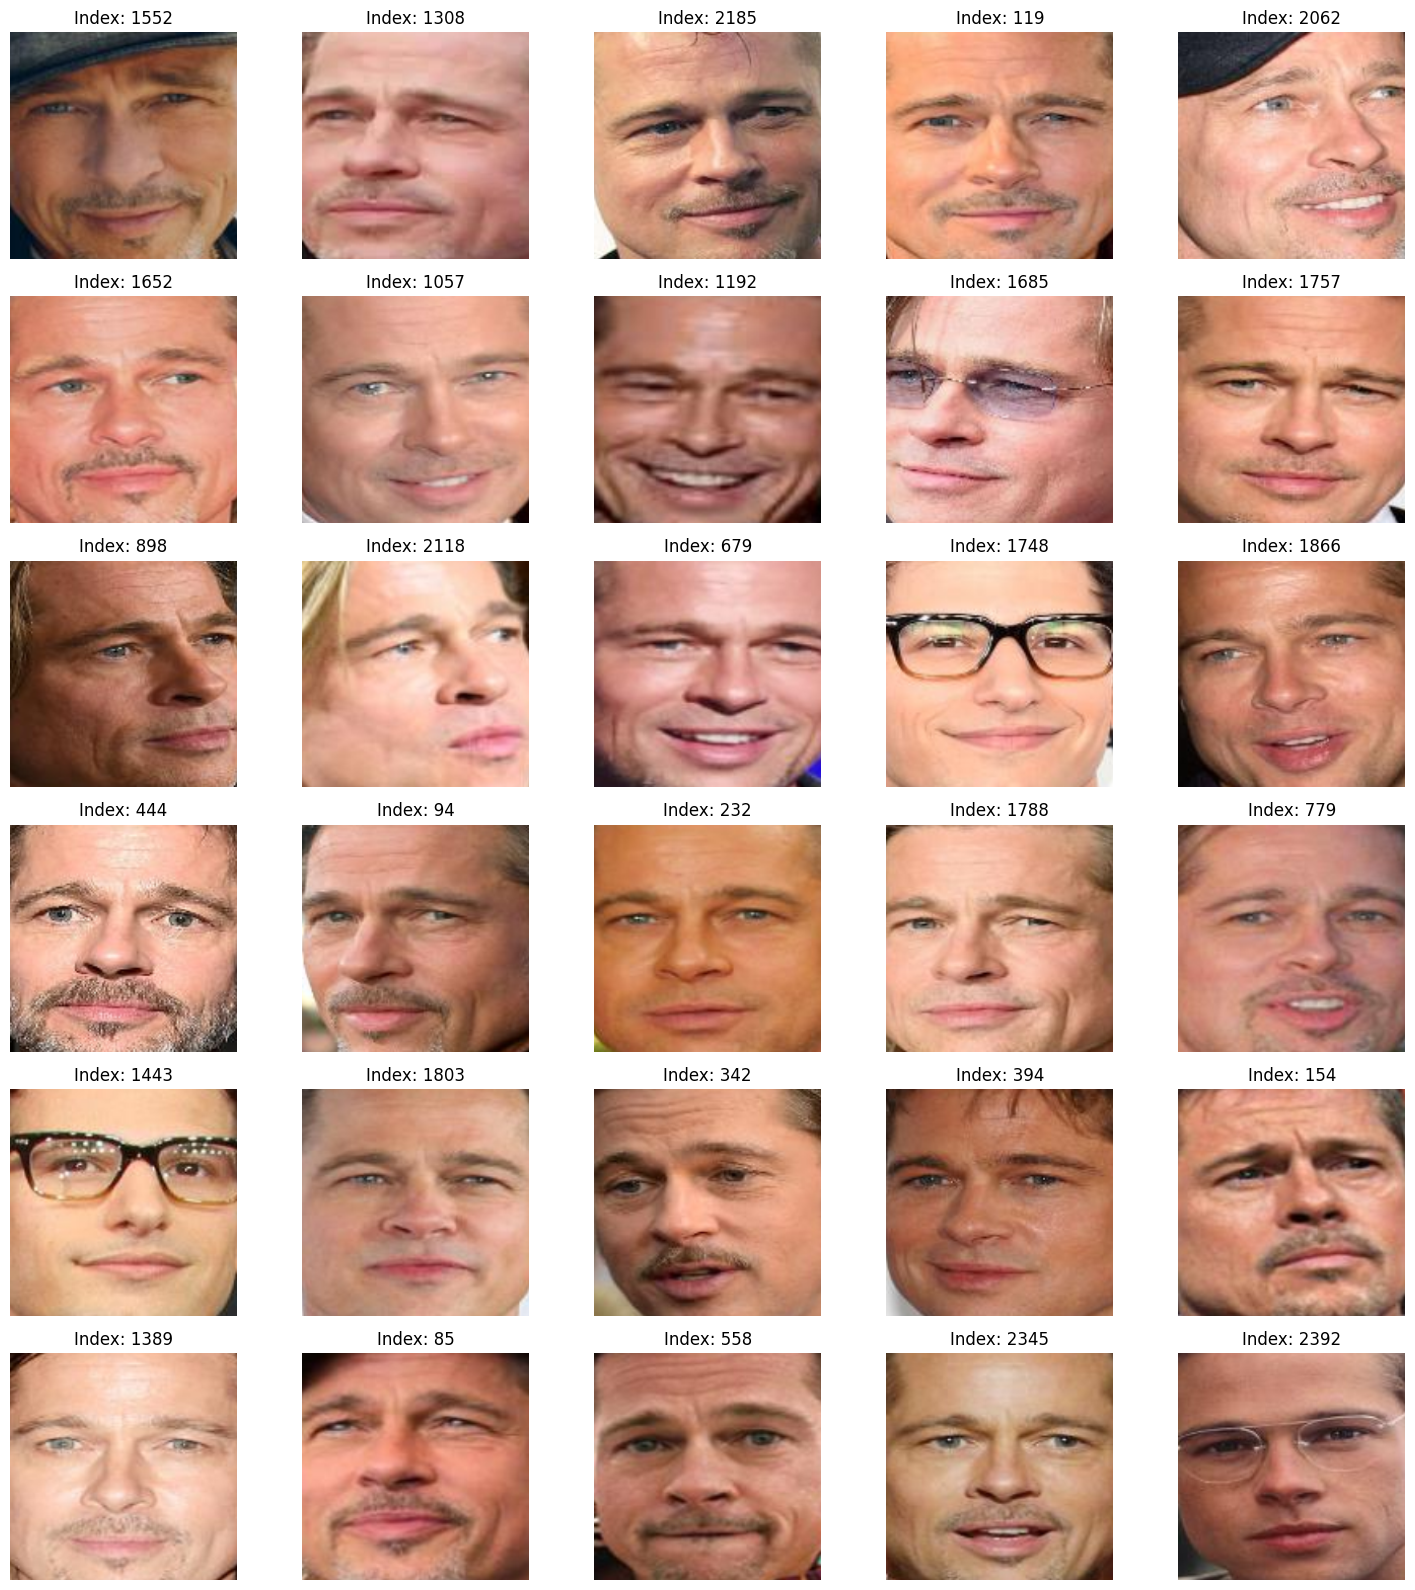

In [43]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(6, 5, figsize=(15, 16))
axes = axes.flatten()

for idx, ax in zip(indices[0].tolist(), axes):
    img_tensor = image_dataset[idx][0]
    img = inverse_transform(img_tensor).permute(1, 2, 0).numpy()
    ax.imshow(img)
    ax.axis('off')
    ax.set_title(f'Index: {idx}')

plt.tight_layout()
plt.show()